In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

import keras.backend as K
import keras
from IPython.display import clear_output


In [ ]:
class_dict = pd.read_csv('/content/sample_data/class_dict.csv')

path_train = '/content/sample_data/train/'
path_train_labels = '/content/sample_data/train_labels/'



In [ ]:
train_images_paths = list(Path(path_train).iterdir())

In [ ]:
path_test = '/content/sample_data/test/'
path_test_labels = '/content/sample_data/test_labels/'
path_val = '/content/sample_data/val/'
path_val_labels = '/content/sample_data/val_labels/'


In [ ]:
single_image = image.load_img(train_images_paths[0])
image_size = (int(single_image.size[0]/2), single_image.size[1])

In [ ]:
train_imgs_paths = list(sorted(Path(path_train).iterdir()))
train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
test_imgs_paths = list(sorted(Path(path_test).iterdir()))
test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
val_imgs_paths = list(sorted(Path(path_val).iterdir()))
val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

In [ ]:
image_size = (128, 192)

In [ ]:
train_images = []
train_masks = []

for i_img, i_mask in zip(train_imgs_paths, train_masks_paths):
    train_images.append(image.load_img(i_img, target_size=image_size))
    train_masks.append(image.load_img(i_mask, target_size=image_size))

In [ ]:
test_images = []
test_masks = []

for i_img, i_mask in zip(test_imgs_paths, test_masks_paths):
    test_images.append(image.load_img(i_img, target_size=image_size))
    test_masks.append(image.load_img(i_mask, target_size=image_size))

In [ ]:
val_images = []
val_masks = []

for i_img, i_mask in zip(val_imgs_paths, val_masks_paths):
    val_images.append(image.load_img(i_img, target_size=image_size))
    val_masks.append(image.load_img(i_mask, target_size=image_size))

In [ ]:
X_train = []

for img in train_images:
  x = image.img_to_array(img)
  X_train.append(x)

X_train = np.array(X_train)

(369, 128, 192, 3)


In [ ]:
X_test = []

for img in test_images:
  x = image.img_to_array(img)
  X_test.append(x)

X_test = np.array(X_test)
print(X_test.shape)

(232, 128, 192, 3)


In [ ]:
X_val = []

for img in val_images:
  x = image.img_to_array(img)
  X_val.append(x)

X_val = np.array(X_val)
print(X_val.shape)

(100, 128, 192, 3)


In [ ]:
arr_col = []

for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
  arr_col.append([r, g, b])

In [ ]:
import cv2


def Color2index(y, arr_col=arr_col):

    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0])
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1
        i += 1

    return y_cat, y_ind#, i-1

In [ ]:
ind_yi

array([[22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       ...,
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.]])

In [ ]:
cat_yi.shape

(128, 192, 32)

In [ ]:
y_train = []

for mask in train_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_train.append(y_cat)

y_train = np.array(y_train)

In [ ]:
y_test = []

for mask in test_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_test.append(y_cat)

y_test = np.array(y_test)

In [ ]:
y_val = []

for mask in val_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_val.append(y_cat)

y_val = np.array(y_val)


In [ ]:
print(X_train.shape)
print(y_train.shape)

(369, 128, 192, 3)
(369, 128, 192, 32)


In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization,
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model


def unet_pre_train(num_classes=32, input_shape=(128, 162, 3)):
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in pre_trained_model.layers[:-5]:
        layer.trainable = False

    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)

    # UP 1

    # добавили перенос из VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [ ]:
model = unet_pre_train(32, (128, 192, 3))

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [ ]:
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 192, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 192, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 96, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
sample_image = X_test[1]
sample_mask = y_test[1]

In [ ]:
def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 16]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 16])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience

    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

2022-03-10 09:12:50.166462: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-10 09:12:51.235202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(1, 128, 192)


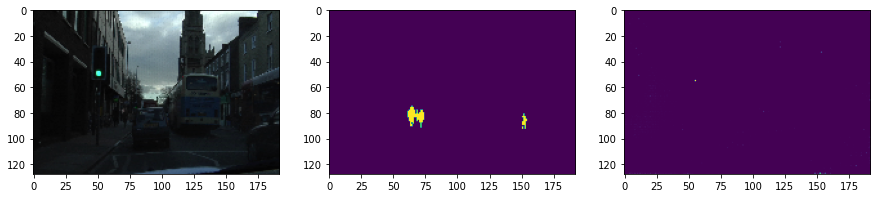

In [ ]:
show_predictions(model)

(1, 128, 192)


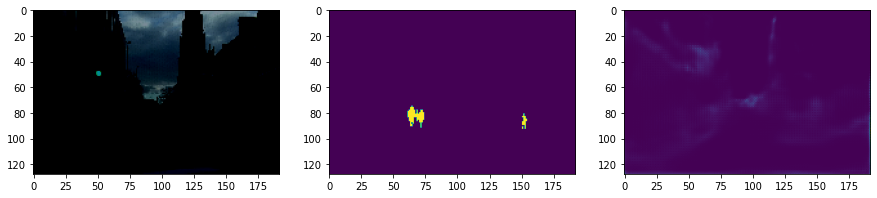


Sample Prediction after epoch 20


In [ ]:
history = model.fit(preprocess_input(X_train), y_train,
                      epochs=20,
                      batch_size=10,
                      validation_data=(preprocess_input(X_test), y_test),
                      callbacks=[DisplayCallback(patience=5)])